In [1]:
import gc
import sys
import scanpy as sc
import decoupler as dc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf as mpdf

from statsmodels.stats.multitest import fdrcorrection

In [2]:
PROJ_DIR = "/lustre/scratch119/casm/team-cvejic/haoliang/results/DownSyndrome/"
IN_DIR = f"{PROJ_DIR}annotated_data/"
GENE_LST = ["MKI67", "GATA1", "ITGA2B", "SPINK2", "CD34", "PROM1"]
OUT_DIR = f"{PROJ_DIR}stem_res_new/"

In [3]:
def restructure(adata2restruct):
    # Parse latest clustring results and remove previous versions
    a = [col[8:] for col in adata2restruct.obs.columns if 'leiden_v' in col]
    max_num = max([int(x) for x in a if x.isdigit()])
    col_name = f"leiden_v{str(max_num)}"
    print(f"\tUsing {col_name} as the latest clustering column.", file=sys.stderr)
    adata2restruct.obs.rename(columns={col_name: "leiden_latest"}, inplace=True)
    # Only keep relevant columns in observations and variables
    adata2restruct.obs.drop([col for col in adata2restruct.obs.columns if ("leiden" in col) and (col != "leiden_latest")],
                            axis=1, inplace=True)
    print(f"\tCell number: {adata2restruct.n_obs}", file=sys.stderr)
    return adata2restruct

# Check Cycling MEMPs

In [6]:
# Subclustering Cycling MEMPs
adata = restructure(sc.read_h5ad(f"{IN_DIR}10X_Healthy_Liver.h5ad"))
print(f"\tCell number after cell type selection: {adata.n_obs}",
      file=sys.stderr)
gc.collect()
# Reclustering
sc.tl.leiden(adata, resolution=1, random_state=0, restrict_to=("leiden_latest", ["Cycling MEMPs"]), key_added="subclusters")

	Using leiden_v7 as the latest clustering column.
	Cell number: 110671
	Cell number after cell type selection: 110671


In [7]:
adata = adata[adata.obs["leiden_latest"].isin(["Cycling MEMPs"]), :]
adata.obs["subclusters"]

AAAGGTAAGGAGAGTA-1-0      Cycling MEMPs,2
AAGCGTTGTGGAAGTC-1-0      Cycling MEMPs,2
AAGCGTTTCCATATGG-1-0     Cycling MEMPs,10
AAGGTAATCAAACGTC-1-0     Cycling MEMPs,10
AAGTACCTCCTATGGA-1-0      Cycling MEMPs,2
                               ...       
TTTCGATGTGCCCACA-1-9      Cycling MEMPs,7
TTTGGAGTCCATGATG-1-9      Cycling MEMPs,0
CTTTCAACATTGCCGG-1-10     Cycling MEMPs,4
GAAGCGACATCTTAGG-1-10     Cycling MEMPs,2
TGTTCTAAGACCATAA-1-10    Cycling MEMPs,10
Name: subclusters, Length: 1340, dtype: category
Categories (14, object): ['Cycling MEMPs,0', 'Cycling MEMPs,1', 'Cycling MEMPs,2', 'Cycling MEMPs,3', ..., 'Cycling MEMPs,10', 'Cycling MEMPs,11', 'Cycling MEMPs,12', 'Cycling MEMPs,13']

/lustre/scratch119/casm/team-cvejic/haoliang/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


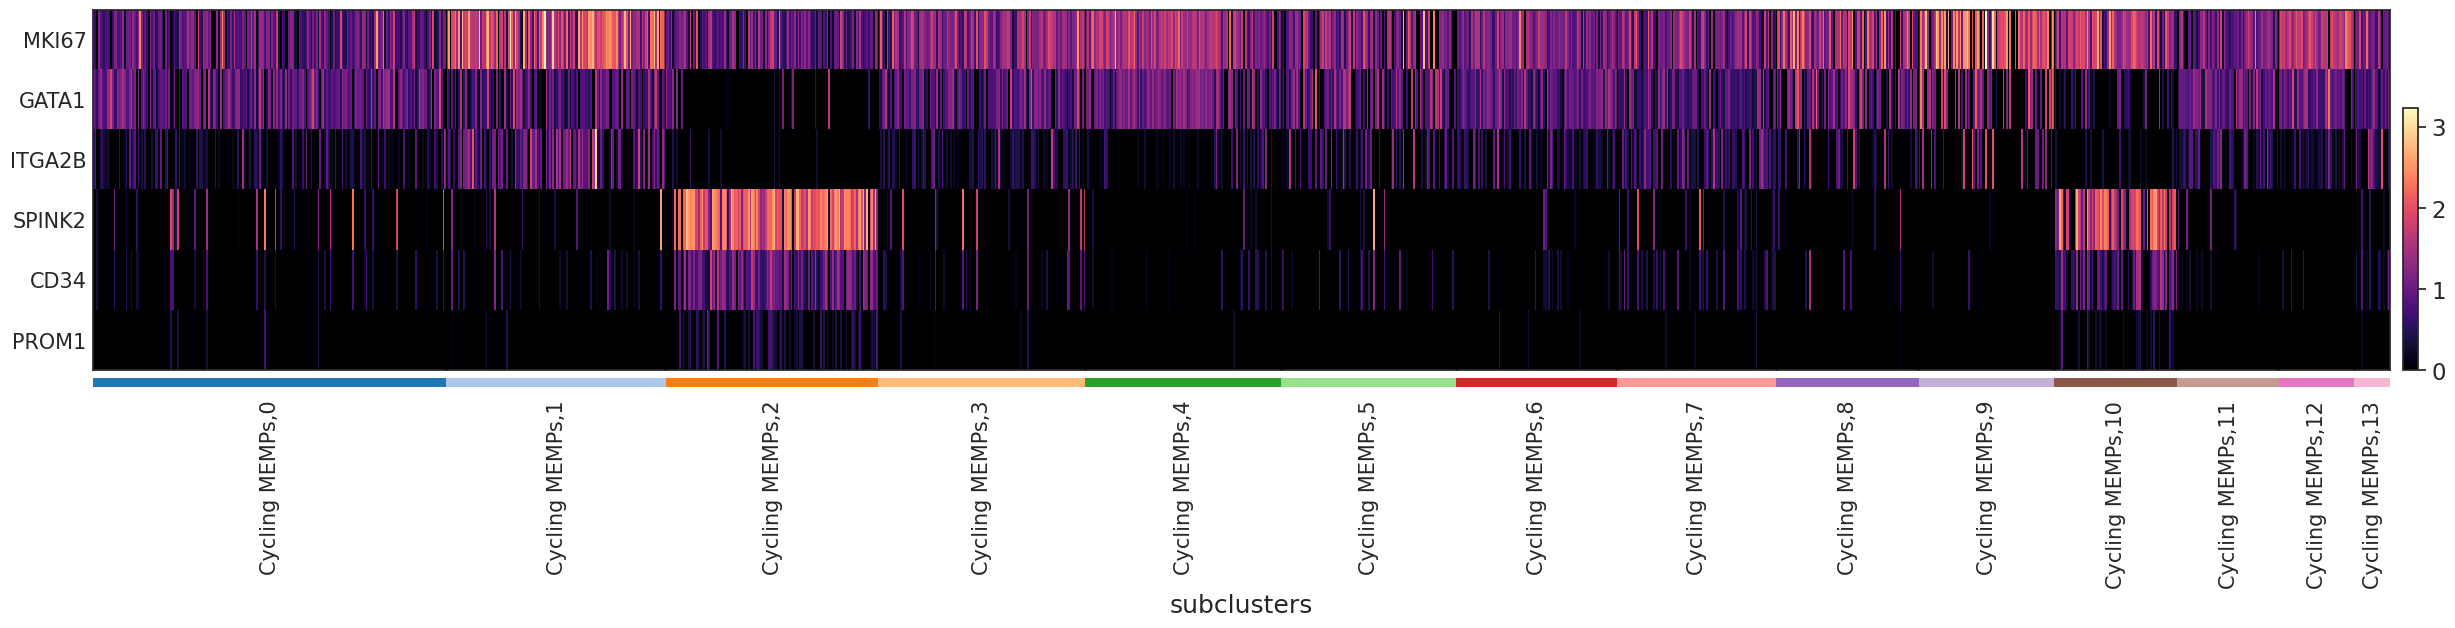

In [8]:
sns.set_theme(style="white", font_scale=1.5)
sc.pl.heatmap(adata, var_names=GENE_LST, groupby=["subclusters"], swap_axes=True,
              figsize=(30, 5), cmap="magma", show=False)
plt.savefig(f"{OUT_DIR}heatmap_inside_Cycling_MEMPs.png")

In [9]:
adata.obs["subclusters"].isin(["Cycling MEMPs,2", "Cycling MEMPs,10"]).sum()

196

In [10]:
cell_idx = adata.obs.index[adata.obs["subclusters"].isin(["Cycling MEMPs,2", "Cycling MEMPs,10"])]
cell_idx

Index(['AAAGGTAAGGAGAGTA-1-0', 'AAGCGTTGTGGAAGTC-1-0', 'AAGCGTTTCCATATGG-1-0',
       'AAGGTAATCAAACGTC-1-0', 'AAGTACCTCCTATGGA-1-0', 'AATGAAGTCTCCCATG-1-0',
       'AATGGCTTCGCTATTT-1-0', 'ACACGCGGTCCCTCAT-1-0', 'ACACTGAAGAATCGTA-1-0',
       'ACGCACGGTAGGTGCA-1-0',
       ...
       'CCTCACAGTCCAGAAG-1-5', 'TTCATTGCAATGTCTG-1-5', 'CCTTGTGGTTCGATTG-1-6',
       'ACGGTCGAGAGGCCAT-1-9', 'GGAATGGCATTATGCG-1-9', 'TCCGATCGTTGCATCA-1-9',
       'TGGTAGTGTGCCCGTA-1-9', 'TGTAAGCAGGATACAT-1-9', 'GAAGCGACATCTTAGG-1-10',
       'TGTTCTAAGACCATAA-1-10'],
      dtype='object', length=196)

# Differential analysis - Healthy

In [11]:
# Subclustering Cycling MEMPs
adata = restructure(sc.read_h5ad(f"{IN_DIR}10X_Healthy_Liver.h5ad"))
print(f"\tCell number after cell type selection: {adata.n_obs}",
      file=sys.stderr)

	Using leiden_v7 as the latest clustering column.
	Cell number: 110671
	Cell number after cell type selection: 110671


In [12]:
adata = adata[(adata.obs["leiden_latest"] == "HSCs/MPPs") | (adata.obs.index.isin(cell_idx)), ].copy()
gc.collect()

12318

In [13]:
adata.obs["leiden_latest"].unique()

['Cycling MEMPs', 'HSCs/MPPs']
Categories (2, object): ['Cycling MEMPs', 'HSCs/MPPs']

In [14]:
adata.obs["leiden_latest"].replace("Cycling MEMPs", "Cycling HSCs/MPPs", inplace=True)

In [15]:
adata.obs[["patient_sample", "leiden_latest"]].value_counts()

patient_sample  leiden_latest    
15781 L15781C   HSCs/MPPs            550
15633 L15633R   HSCs/MPPs            285
15657 F15657G   HSCs/MPPs            212
15633 L15633A   Cycling HSCs/MPPs    177
                HSCs/MPPs            149
15781 L15781A   HSCs/MPPs             67
15633 L15633R   Cycling HSCs/MPPs      7
15633 L15633B   HSCs/MPPs              6
15781 L15781C   Cycling HSCs/MPPs      5
15657 F15657G   Cycling HSCs/MPPs      3
15657 L15657A   HSCs/MPPs              2
15781 L15781D   Cycling HSCs/MPPs      2
                HSCs/MPPs              2
15633 L15633B   Cycling HSCs/MPPs      1
15657 L15657A   Cycling HSCs/MPPs      1
dtype: int64

In [16]:
adata.obs["leiden_latest"].value_counts()

HSCs/MPPs            1273
Cycling HSCs/MPPs     196
Name: leiden_latest, dtype: int64

## Pseudobulking

In [17]:
padata = dc.get_pseudobulk(adata, sample_col="patient_sample", groups_col="leiden_latest", min_cells=5)

In [18]:
padata

View of AnnData object with n_obs × n_vars = 8 × 7429
    obs: 'patient', 'sample', 'organ', 'age', 'sorting', 'mean reads/cell', 'median genes/cell', 'environment', '# isolated cells', '# estimated cells', 'sangerID', 'batch', 'patient_sample', 'exp', 'leiden_latest', 'annotations_atac', 'annotations_atac_v2'

In [21]:
pd.DataFrame(padata.X,
             columns=padata.var.index,
             index=padata.obs.index).to_csv(f"{OUT_DIR}Healthy_Liver_stem_pseudobulk_expression.csv")

In [ ]:
# Normalize
sc.pp.normalize_total(padata, target_sum=1e4)
sc.pp.log1p(padata)
padata

## Wilcoxon test

In [ ]:
logFCs1, pvals1 = dc.get_contrast(padata, group_col=None, condition_col="leiden_latest",
                                  condition="Cycling HSCs/MPPs", reference="HSCs/MPPs",
                                  method="wilcoxon")
padjs1 = fdrcorrection(pvals1.T["Cycling HSCs/MPPs.vs.HSCs/MPPs"], alpha=0.05, method="indep", is_sorted=False)[1]

## T-test

In [ ]:
logFCs2, pvals2 = dc.get_contrast(padata, group_col=None, condition_col="leiden_latest",
                                  condition="Cycling HSCs/MPPs", reference="HSCs/MPPs",
                                  method="t-test")
padjs2 = fdrcorrection(pvals2.T["Cycling HSCs/MPPs.vs.HSCs/MPPs"], alpha=0.05, method="indep", is_sorted=False)[1]

## Summarise results

In [ ]:
res = pd.concat([logFCs1.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "Wilcoxon LogFC"}),
                 pvals1.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "Wilcoxon pval"}),
                 pd.DataFrame(padjs1, index=pvals1.T.index, columns=["Wilcoxon FDR"]),
                 logFCs2.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "T-test LogFC"}),
                 pvals2.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "T-test pval"}),
                 pd.DataFrame(padjs2, index=pvals2.T.index, columns=["T-test FDR"])],
                axis=1).sort_values("T-test FDR")
(res["Wilcoxon LogFC"] == res["T-test LogFC"]).all()

In [ ]:
res.drop(columns=["T-test LogFC"]).rename(columns={"Wilcoxon LogFC": "LogFC"}).to_csv(f"{OUT_DIR}Hth_pseudo_analysis_cycStem_vs_stem.csv")

In [ ]:
print("Wilcoxon significant number:", (res["Wilcoxon FDR"] < 0.05).sum())

In [ ]:
print("T-test significant number:", (res["T-test FDR"] < 0.05).sum())

In [ ]:
del adata
gc.collect()

# Differential analysis - DS

In [22]:
# Subclustering Cycling MEMPs
adata = restructure(sc.read_h5ad(f"{IN_DIR}10X_DownSyndrome_Liver.h5ad"))
print(f"\tCell number after cell type selection: {adata.n_obs}",
      file=sys.stderr)

	Using leiden_v10 as the latest clustering column.
	Cell number: 780299
	Cell number after cell type selection: 780299


In [23]:
adata = adata[adata.obs["leiden_latest"].isin(["HSCs/MPPs", "Cycling HSCs/MPPs"]), ].copy()
gc.collect()

4458

In [24]:
adata.obs["leiden_latest"].unique()

['Cycling HSCs/MPPs', 'HSCs/MPPs']
Categories (2, object): ['Cycling HSCs/MPPs', 'HSCs/MPPs']

In [25]:
adata.obs[["patient_sample", "leiden_latest"]].value_counts()

patient_sample     leiden_latest    
15636 L15636B      HSCs/MPPs            2547
15669 15669H       HSCs/MPPs            2297
15646 15646A       HSCs/MPPs            2294
15724 15724C       HSCs/MPPs            2177
15532 L15532M      HSCs/MPPs            1997
                                        ... 
15712 L15712Q      Cycling HSCs/MPPs      17
15582 T21 15582 A  Cycling HSCs/MPPs      17
15669 L15669N      Cycling HSCs/MPPs      15
15656 L15656I      Cycling HSCs/MPPs      14
15646 L15646H      Cycling HSCs/MPPs      10
Length: 100, dtype: int64

## Pseudobulking

In [26]:
padata = dc.get_pseudobulk(adata, sample_col="patient_sample", groups_col="leiden_latest", min_cells=10)

In [27]:
padata

View of AnnData object with n_obs × n_vars = 99 × 9973
    obs: 'patient', 'sample', 'organ', 'age', 'sorting', 'mean reads/cell', 'median genes/cell', 'environment', '# isolated cells', '# estimated cells', 'sangerID', 'batch', 'patient_sample', 'exp', 'leiden_latest', 'annotations_atac'

In [28]:
pd.DataFrame(padata.X,
             columns=padata.var.index,
             index=padata.obs.index).to_csv(f"{OUT_DIR}DownSyndrome_Liver_stem_pseudobulk_expression.csv")

In [ ]:
# Normalize
sc.pp.normalize_total(padata, target_sum=1e4)
sc.pp.log1p(padata)
padata

## Wilcoxon test

In [ ]:
logFCs1, pvals1 = dc.get_contrast(padata, group_col=None, condition_col="leiden_latest",
                                  condition="Cycling HSCs/MPPs", reference="HSCs/MPPs",
                                  method="wilcoxon")
padjs1 = fdrcorrection(pvals1.T["Cycling HSCs/MPPs.vs.HSCs/MPPs"], alpha=0.05, method="indep", is_sorted=False)[1]

## T-test

In [ ]:
logFCs2, pvals2 = dc.get_contrast(padata, group_col=None, condition_col="leiden_latest",
                                  condition="Cycling HSCs/MPPs", reference="HSCs/MPPs",
                                  method="t-test")
padjs2 = fdrcorrection(pvals2.T["Cycling HSCs/MPPs.vs.HSCs/MPPs"], alpha=0.05, method="indep", is_sorted=False)[1]

## Summarise results

In [ ]:
res = pd.concat([logFCs1.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "Wilcoxon LogFC"}),
                 pvals1.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "Wilcoxon pval"}),
                 pd.DataFrame(padjs1, index=pvals1.T.index, columns=["Wilcoxon FDR"]),
                 logFCs2.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "T-test LogFC"}),
                 pvals2.T.rename(columns={"Cycling HSCs/MPPs.vs.HSCs/MPPs": "T-test pval"}),
                 pd.DataFrame(padjs2, index=pvals2.T.index, columns=["T-test FDR"])],
                axis=1).sort_values("T-test FDR")
(res["Wilcoxon LogFC"] == res["T-test LogFC"]).all()

In [ ]:
res.drop(columns=["T-test LogFC"]).rename(columns={"Wilcoxon LogFC": "LogFC"}).to_csv(f"{OUT_DIR}DS_pseudo_analysis_cycStem_vs_stem.csv")

In [ ]:
print("Wilcoxon significant number:", (res["Wilcoxon FDR"] < 0.05).sum())

In [ ]:
print("T-test significant number:", (res["T-test FDR"] < 0.05).sum())